# Apple Stock price prediction

In [385]:
# Installing the required libraries
# !pip install yfinance

# !pip install statsmodels 

# !pip install pmdarima

# !pip install plotly

In [386]:
# importing all the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf

In [387]:
# Ticker symbols are used to identify publicly traded shares of a particular stock on a particular stock market.
ticker = 'AAPL'

aapl = yf.download(ticker, start="2015-01-01")
aapl = aapl.dropna()

aapl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402170,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714716,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716957,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049515,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973555,237458000


In [388]:
aapl.shape

(2361, 6)

### Exploratory Data Analysis

In [389]:
aapl['Close'].describe()

count    2361.000000
mean       87.943026
std        58.067791
min        22.584999
25%        36.029999
50%        55.959999
75%       146.350006
max       198.110001
Name: Close, dtype: float64

Text(0.5, 1.0, 'Closing Price')

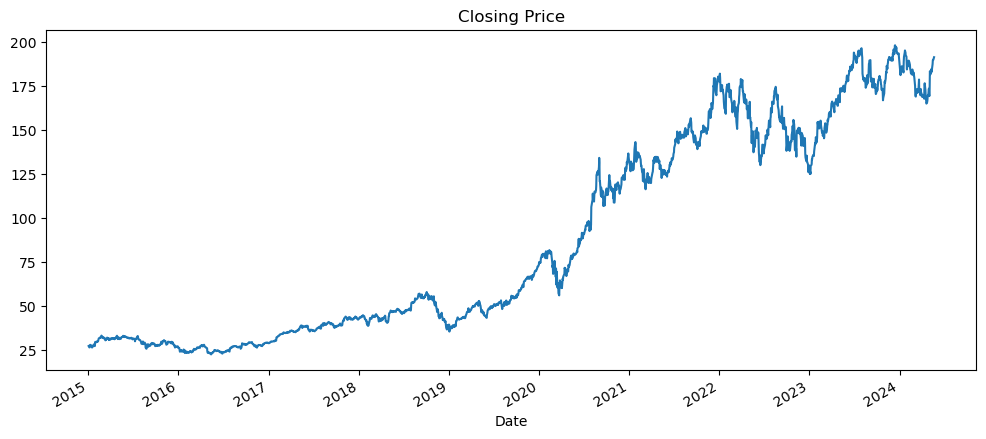

In [390]:
# Plotting the closing price
aapl['Close'].plot(figsize = (12,5))
plt.title("Closing Price")

In [391]:
# Plotting a candlestick chart
import plotly.graph_objects as go
candle = go.Figure(data=[go.Candlestick(x=aapl.index,
                                        open=aapl['Open'][:100],
                                        high=aapl['High'][:100],
                                        low=aapl['Low'][:100],
                                        close=aapl['Close'][:100])])

# Add titles, labels, and adjust the figure size
candle.update_layout(title='Apple Inc. Stock Price (First 100 days)',
                     xaxis_title='Date',
                     yaxis_title='Price',
                     xaxis_rangeslider_visible=False,
                     width=1000,  # Set the width of the figure
                     height=800)  # Set the height of the figure

candle.show()

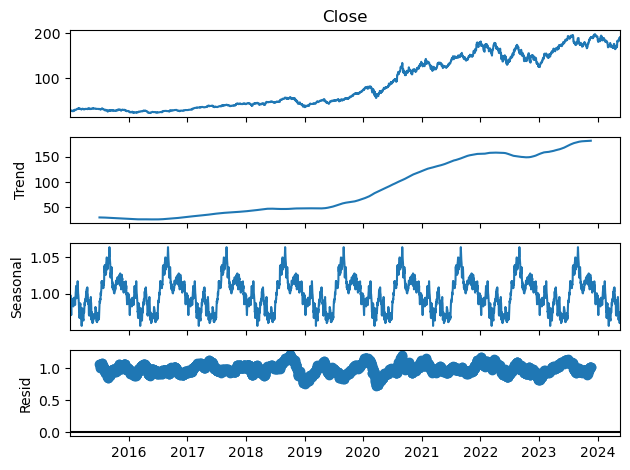

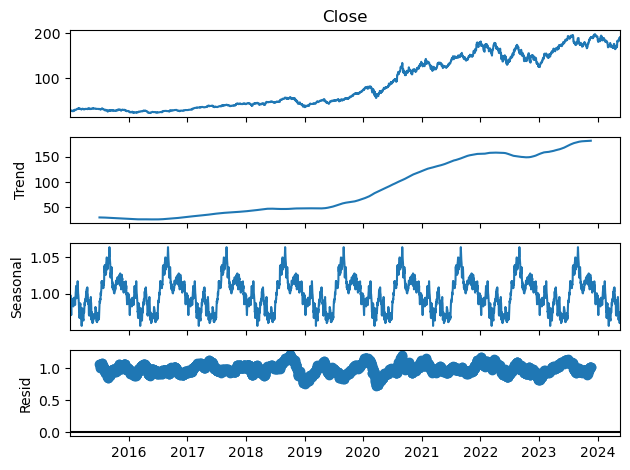

In [392]:
from statsmodels.tsa.seasonal import seasonal_decompose
aapl_copy = aapl.copy()
aapl_copy.index = pd.to_datetime(aapl_copy.index)
aapl_copy.index = pd.DatetimeIndex(aapl_copy.index)
# Reindex to include all dates
all_dates = pd.date_range(start=aapl_copy.index.min(), end=aapl_copy.index.max(), freq='D')
aapl_copy = aapl_copy.reindex(all_dates)

# Fill missing values, inplace = True replaces the current dataframe
# Use ffill (forward fill) or bfill (back fill) 
# ffill brings the previous value forward to fill the missing value
# bfill brings the value after the missing value back to fill the missing value
aapl_copy.ffill(inplace=True)  

# Set the frequency
aapl_copy.index.freq = 'D'
results = seasonal_decompose(aapl_copy['Close'], model = 'multiplicative', period = 365)
results.plot()

Any time series data that needs to be modelled needs to be stationary
- Constant mean
- Constant variance
- No seasonality

Before I start fitting in the model, need to check for stationarity. But in first glance, it is <b>NOT</b> stationary

I will be using the `Augmented Dickey-Fuller` (ADF) test to check for stationarity from `statsmodels` library

In [393]:
from statsmodels.tsa.stattools import adfuller

In [394]:
# Creating a function so we can use it for other timeseries (open, close, high or low)
def adf_test(timeseries):
    # The adfuller function will return a list
    stat_result = adfuller(timeseries, autolag = 'AIC')
    print("1. ADF : ",stat_result[0])
    print("2. P-Value : ", stat_result[1])
    print("3. Num Of Lags : ", stat_result[2])
    print("4. Num Of Observations Used For ADF Regression:", stat_result[3])
    print("5. Critical Values :")
    for key, val in stat_result[4].items():
        print("\t",key, ": ", val)
        
# I will be looking into the closing price for now
adf_test(aapl['Close'])

1. ADF :  -0.04837196392129266
2. P-Value :  0.9543442084738252
3. Num Of Lags :  18
4. Num Of Observations Used For ADF Regression: 2342
5. Critical Values :
	 1% :  -3.43314525271574
	 5% :  -2.862774891185521
	 10% :  -2.5674273865936037


According to the ADF test, p-value > 0.5, hence data not stationary

In [395]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(aapl['Close'], max_p=10, max_d=10, max_q=10, trace=True, suppress_warnings=True)

# Print the summary of the best model
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9633.675, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9630.259, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9630.591, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9630.508, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9631.552, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9631.114, Time=0.75 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.874 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2361
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4813.129
Date:                Mon, 20 May 2024   AIC                           9630.259
Time:                        23:29:28   BIC                           9641.792
Sample:                             0   HQIC                          9634.458
          

Using the `auto_arima` function in `pmdarima` library allows me to find significant orders for the Auto-Regression (AR) model, differencing and Moving Average (MA) model

From the result above, the AR model has zero order, differencing has a order of 1 and MA model has zero order

### Autoregressive Integrated Moving Average (ARIMA) model

In [396]:
# Splitting into train and test set
train = aapl[:len(aapl)-365]
test = aapl[len(aapl)-365:]
# Check  if the data is correctly split
print(train.shape)
print(test.shape)

(1996, 6)
(365, 6)


In [397]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Close'], order=(0,1,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1996
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3967.993
Date:                Mon, 20 May 2024   AIC                           7937.985
Time:                        23:29:28   BIC                           7943.584
Sample:                             0   HQIC                          7940.041
                               - 1996                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.1269      0.045     68.974      0.000       3.038       3.216
===================================================================================
Ljung-Box (L1) (Q):                   7.64   Jarque-Bera (JB):              4743.30
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              42.04   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



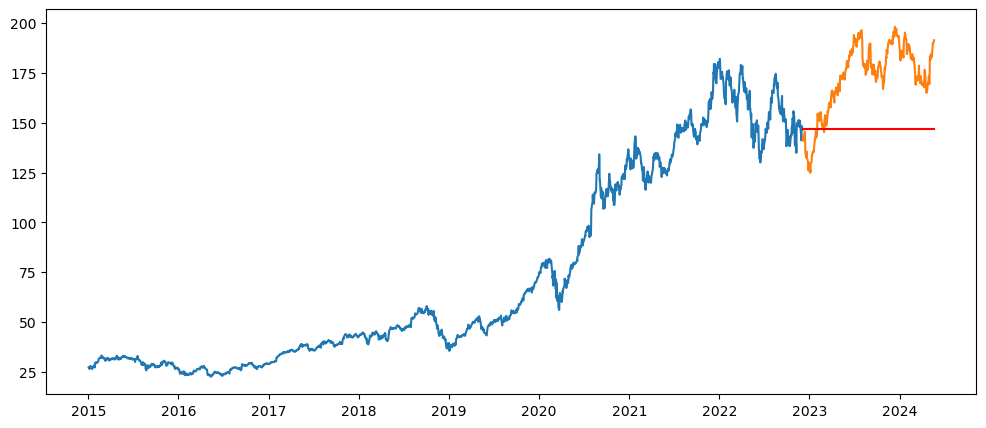

In [398]:
# Checking how good the model is
start_date = len(train)
end_date = len(train) + len(test)-1

# Make predictions in levels
pred=model_fit.predict(start=start_date,end=end_date, typ = 'levels')
plt.figure(figsize=(12, 5))  

# Plot the original data
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, pred, label='Predictions', color='red')


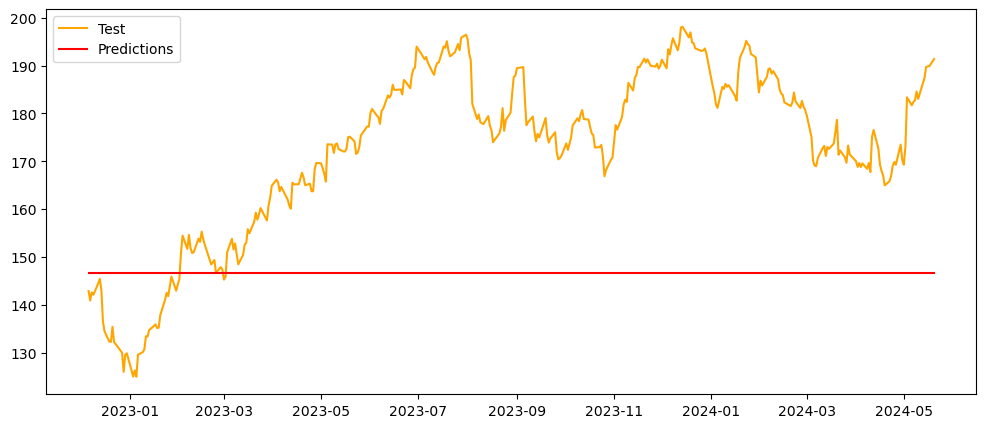

In [399]:
plt.figure(figsize = (12,5))
plt.plot(test.index, test['Close'], label='Test', color = 'orange')
plt.plot(test.index, pred, label='Predictions', color='red')
plt.legend()

In [400]:
# Finding the metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
mean = test['Close'].mean()
rmse=sqrt(mean_squared_error(pred,test['Close']))
print(f'Mean: {mean}')
print(f"MSE: {mean_squared_error(pred,test['Close'])}")
print(f'RMSE: {rmse}')

Mean: 172.56858911383642
MSE: 975.197843196898
RMSE: 31.228157857883613


### Seasonal Autoregressive Integrated Moving Average with Exogenous factors (SARIMAX) model

In [401]:
# Using the auto_arima function again to find the optimal seasonal orders for the SARIMAX model
# m = 7 represents weekly seasonality as the data is daily
sarimax_fit = auto_arima(aapl['Close'], seasonal = True,
                        m = 7,
                        max_p = 10, max_P = 10,
                        max_q = 10, max_Q = 10,
                        max_d = 10, max_D = 10,
                        trace = True,
                        supress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=9636.733, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9630.259, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9629.471, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=9629.431, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9631.552, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=9630.508, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=9631.349, Time=0.94 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=9631.325, Time=1.39 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=9629.395, Time=0.32 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=9631.336, Time=0.66 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=9633.359, Time=0.76 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=9628.837, Time=0.24 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=9630.752, Time=0.56 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=9630.769, Time=0.65 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept

Again, I have used the `auto_arima` function to find the optimal seasonal order for the SARIMAX model and results are as follows:
- Seasonal AR order: 1
- Seasonal differencing: 0
- Seasonal MA order: 0
- Seasonal period: 7

In [402]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(aapl['Close'], order=(0, 1, 0), seasonal_order=(1, 0, 0, 7), enforce_stationarity=True)

# Fit the model on the data
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

pred = model_fit.predict()

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 2361
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 7)   Log Likelihood               -4812.947
Date:                           Mon, 20 May 2024   AIC                           9629.894
Time:                                   23:29:41   BIC                           9641.427
Sample:                                        0   HQIC                          9634.093
                                          - 2361                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.0394      0.014      2.793      0.005       0.012       0.067
sigma2         3.4586      0.050     69.039

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



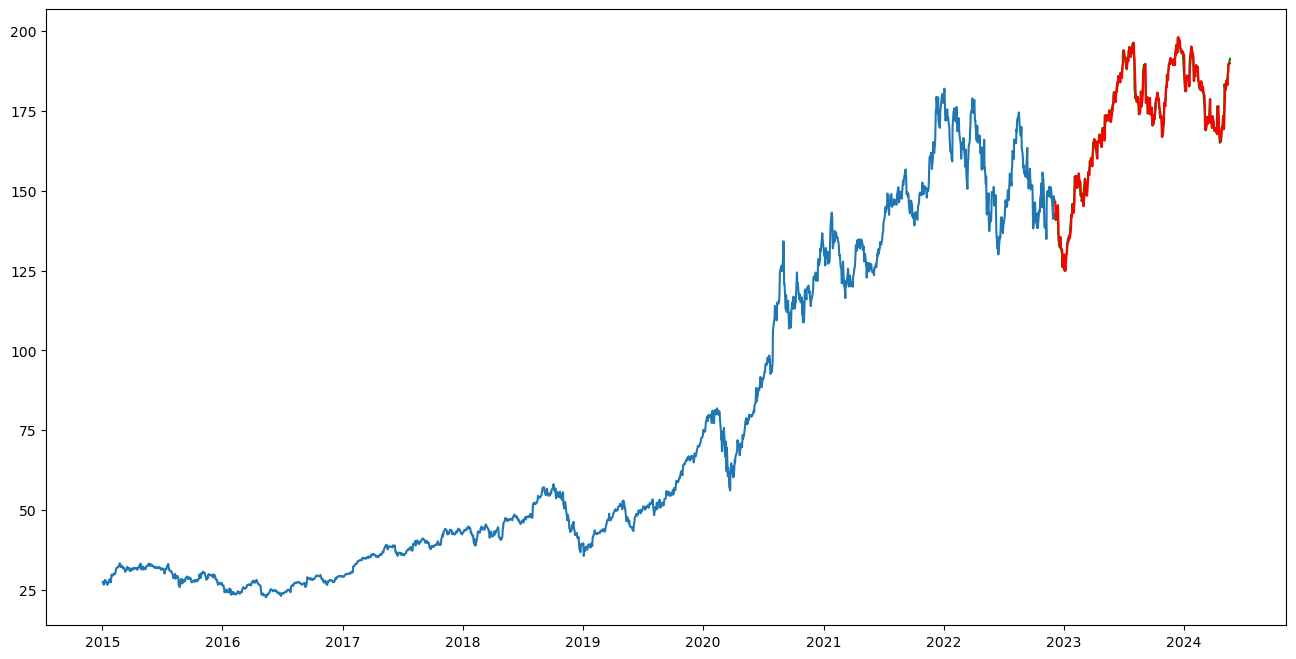

In [403]:
pred=model_fit.predict(start=start_date,end=end_date, typ = 'levels')
plt.figure(figsize=(16, 8))  

# Plot the original data
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test', color = 'green')
plt.plot(test.index, pred, label='Predictions', color='red')

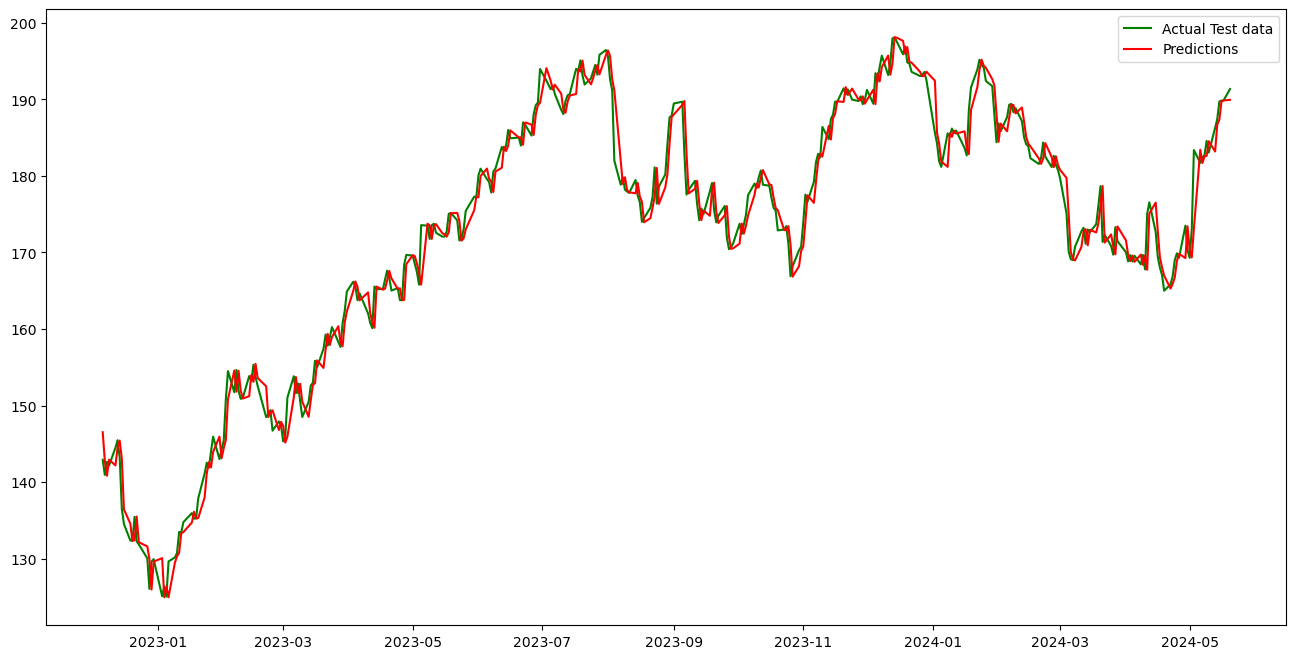

In [404]:
plt.figure(figsize = (16,8))
plt.plot(test.index, test['Close'], label='Actual Test data', color = 'green')
plt.plot(test.index, pred, label='Predictions', color='red')
plt.legend()

In [405]:
mean = test['Close'].mean()
rmse=sqrt(mean_squared_error(pred,test['Close']))
print(f'Mean: {mean}')
print(f"MSE: {mean_squared_error(pred,test['Close'])}")
print(f'RMSE: {rmse}')

Mean: 172.56858911383642
MSE: 5.280900927885459
RMSE: 2.298021089521473


2361    191.295176
2362    191.422293
2363    191.467551
2364    191.557675
2365    191.562398
2366    191.563578
2367    191.622021
2368    191.619667
2369    191.624669
2370    191.626451
Name: predicted_mean, dtype: float64


C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Text(0.5, 1.0, 'Forecast for the next 10 days')

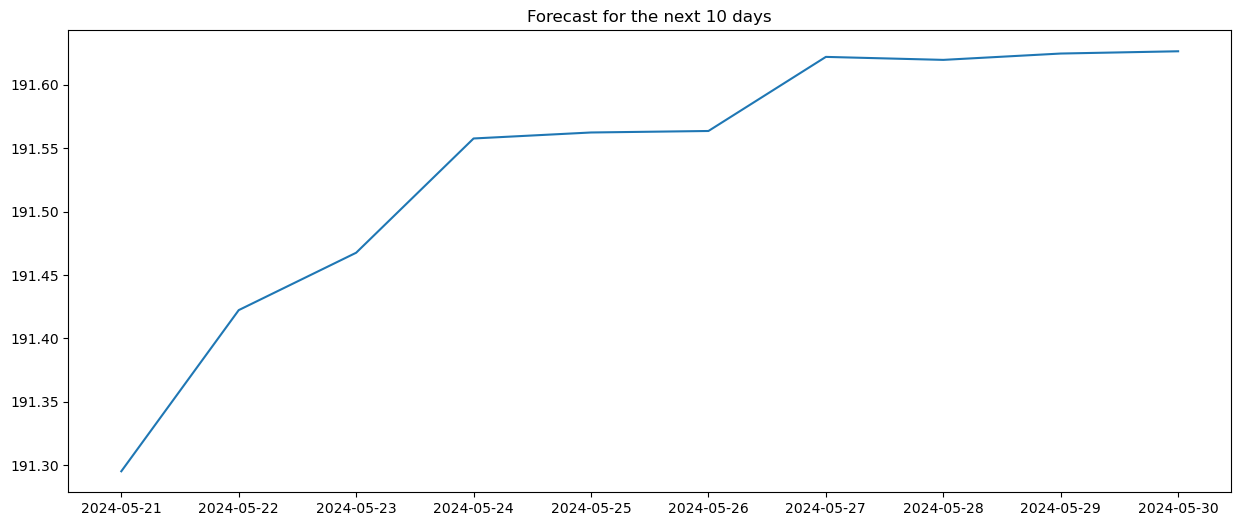

In [406]:
forecast = model_fit.forecast(steps=10)
print(forecast)
datetime = pd.date_range(start = aapl.index.max() + pd.Timedelta(days=1), end = aapl.index.max() + pd.Timedelta(days=10))
plt.figure(figsize = (15,6))
plt.plot(datetime, forecast)
plt.title('Forecast for the next 10 days')

### Long Short Term Memory (LSTM) model

In [407]:
# install tensorflow
# !pip install tensorflow

In [408]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [409]:
data_copy = aapl.copy()
data_close = pd.DataFrame(data_copy['Close'])
data_close.set_index(data_copy.index, inplace = True)
train_set = data_close[:len(data_close)-365]
test_set = data_close[len(data_close)-365:]
# Scale the train and test set
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_set)
scaled_test = scaler.transform(test_set)

In [410]:
# Prepare the input and output sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Weekly prediction
sequence_length = 7
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

In [411]:
# Build the LSTM model
model = Sequential()
# 100 here represents number of units of LSTM layer
model.add(LSTM(100, activation = 'relu', input_shape = (sequence_length, 1))) # 1 because it is univariate
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# Prediction on test set
predictions = model.predict(X_test)

Epoch 1/100


C:\Users\victo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0840 - val_loss: 0.0039
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9753e-04 - val_loss: 0.0014
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3638e-04 - val_loss: 9.1252e-04
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5142e-04 - val_loss: 9.1489e-04
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3722e-04 - val_loss: 8.8188e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9735e-04 - val_loss: 7.1356e-04
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3281e-04 - val_loss: 7.7763e-04
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1383e-04 - val_loss: 0.0012
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2280e-04 - val_loss: 7.2931e-04
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1632e-04 - val_loss: 6.9844e-04
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8038e-04 - val_loss: 7.0878e-04
Epo

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4852e-04 - val_loss: 3.6872e-04
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5717e-04 - val_loss: 2.7633e-04
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6542e-04 - val_loss: 3.5176e-04
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7027e-04 - val_loss: 0.0016
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4308e-04 - val_loss: 3.3223e-04
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7567e-04 - val_loss: 6.5437e-04
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9176e-04 - val_loss: 3.1622e-04
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0411e-04 - val_loss: 2.5779e-04
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6645e-04 - val_loss: 3.3673e-04
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5517e-04 - val_loss: 2.5159e-04
Epoch 75/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4081e-04 - val_

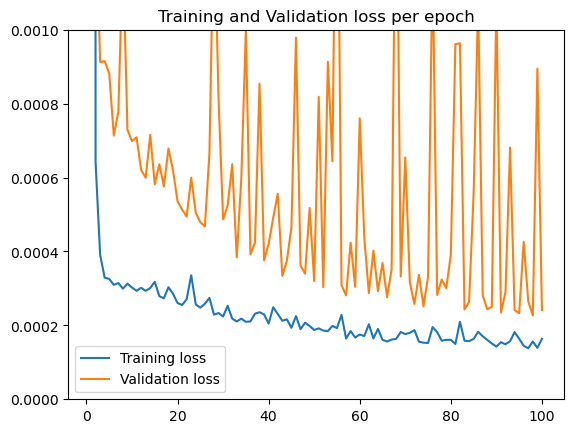

In [412]:
# Plotting training and validation loss per epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.ylim(top = 0.001)
plt.title('Training and Validation loss per epoch')
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.legend()

In [413]:
# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

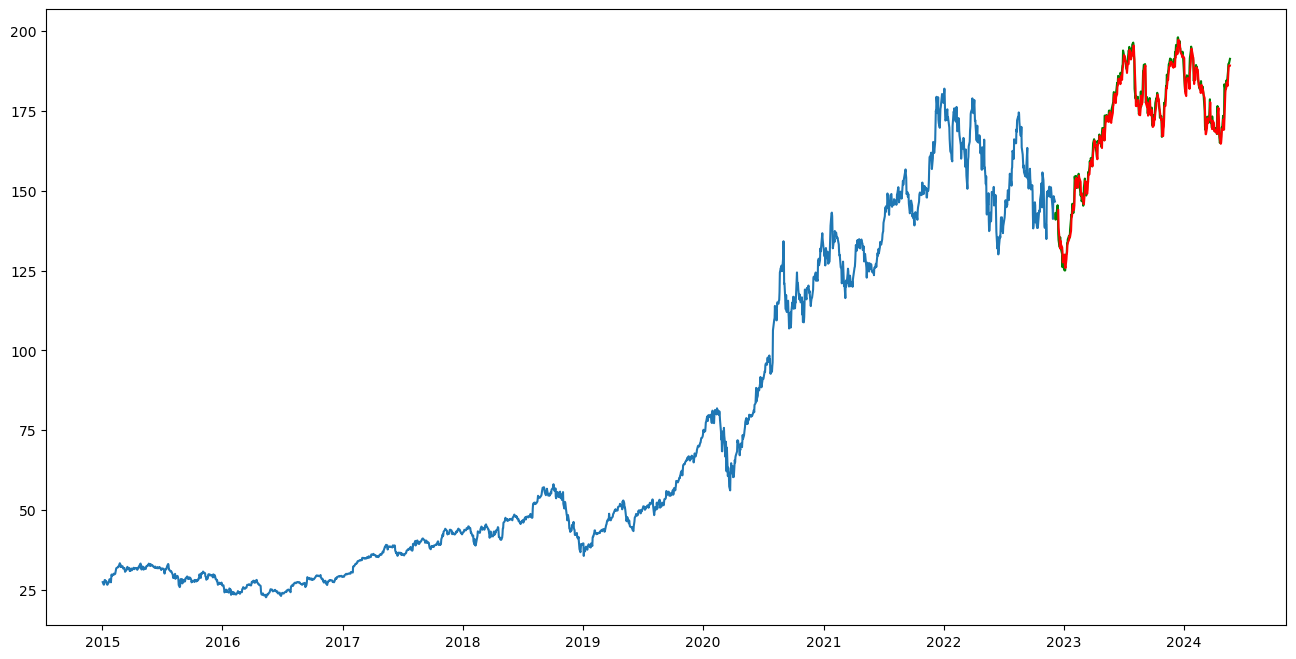

In [414]:
plt.figure(figsize=(16, 8))  

# Plot the original data
plt.plot(train_set.index, train_set['Close'], label='Train')
plt.plot(test_set.index, test_set['Close'], label='Test', color = 'green')
plt.plot(test_set[sequence_length:].index, predictions, label='Predictions', color='red')

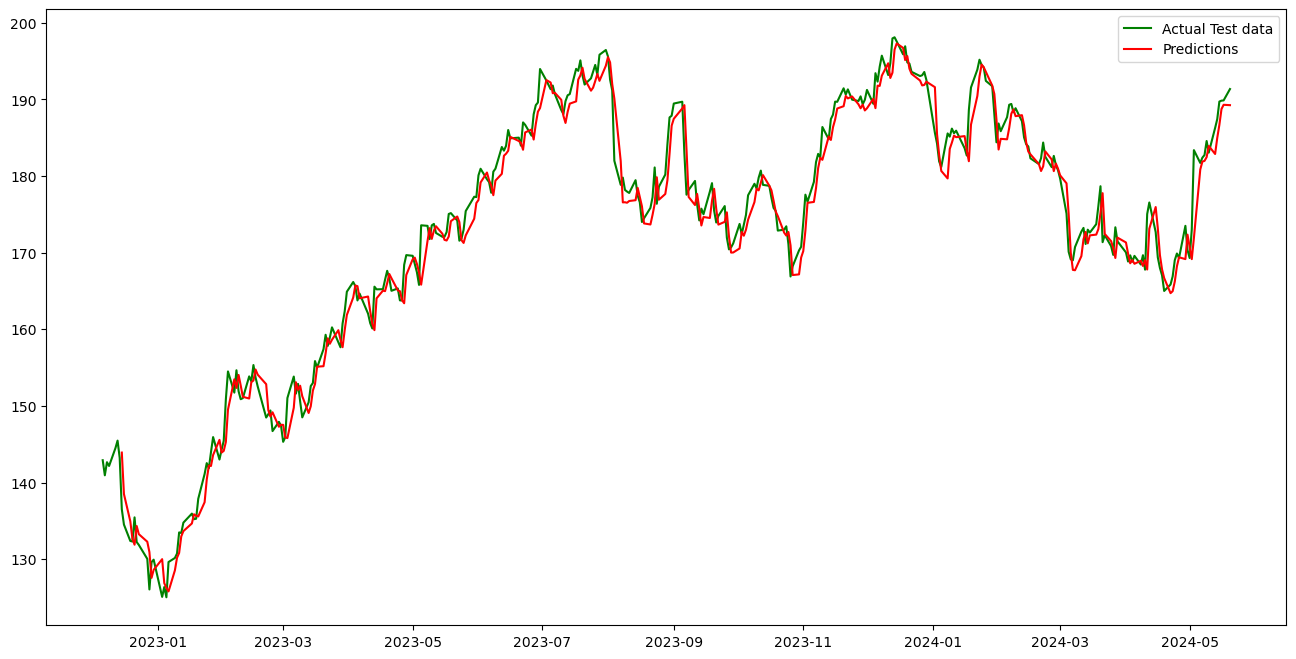

In [415]:
plt.figure(figsize = (16,8))
plt.plot(test.index, test['Close'], label='Actual Test data', color = 'green')
plt.plot(test_set[sequence_length:].index, predictions, label='Predictions', color='red')
plt.legend()

In [416]:
mean = test['Close'].mean()
rmse=sqrt(mean_squared_error(predictions,test['Close'][sequence_length:]))
print(f'Mean: {mean}')
print(f"MSE: {mean_squared_error(predictions,test['Close'][sequence_length:])}")
print(f'RMSE: {rmse}')

Mean: 172.56858911383642
MSE: 6.129582520610102
RMSE: 2.475799370023771


## Conclusion

SARIMAX model have the lowest Root mean square error (RMSE) compared to ARIMAX and LSTM model. Hence SARIMAX would be a better model in forecasting apple stock price.